In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

In [27]:
stock_prices = pd.read_csv('stock_prices.csv')
book_to_market = pd.read_csv('book_to_market.csv')

book_to_market = book_to_market.drop(['permno', 'adate', 'qdate'], axis = 1)
book_to_market = book_to_market.rename(columns = {'bm' : 'book_to_market', 'public_date' : 'date', 'TICKER' : 'tic'})
book_to_market['date'] =  pd.to_datetime(book_to_market['date'], format='%Y-%m-%d')
book_to_market['date'] = book_to_market['date'].dt.to_period('M')

stock_prices = stock_prices.drop(['gvkey', 'iid', 'navm', 'cmth', 'cyear', 'exchg', 'conm'], axis = 1)
stock_prices = stock_prices.rename(columns = {'datadate' : 'date', 'prccm' : 'price_close', 'prchm' : 'price_high', 'prclm' : 'price_low'})
stock_prices['date'] =  pd.to_datetime(stock_prices['date'], format='%Y-%m-%d')
stock_prices['date'] = stock_prices['date'].dt.to_period('M')

df_tic = pd.merge(book_to_market, stock_prices, how = 'left', on = ['tic', 'date'])
df_tic = df_tic[['date', 'tic', 'book_to_market', 'price_close', 'price_high', 'price_low']]
df_tic = df_tic.set_index('date')

#Filter relevant stocks for Group 42
df_tickers = pd.read_excel("Tickers_T4.xlsx", usecols=["Group 42"])
tickers = df_tickers['Group 42'].tolist()

# Filter the df_tic DataFrame based on the tickers
df_tic = df_tic[df_tic['tic'].isin(tickers)]

display(df_tic)
# df_tic.info()


,tic,book_to_market,price_close,price_high,price_low
date,,,,,
1980-01,ABC,0.569,NaN,NaN,NaN
1980-02,ABC,0.696,NaN,NaN,NaN
1980-03,ABC,0.696,NaN,NaN,NaN
1980-04,ABC,0.696,NaN,NaN,NaN
1980-05,ABC,0.866,NaN,NaN,NaN
...,...,...,...,...,...
2022-08,FTNT,0.014,48.69,63.160,48.3100
2022-09,FTNT,0.014,49.13,55.940,47.3700
2022-10,FTNT,0.014,57.16,57.335,45.7400


**1. Present annualized performance statistics (average return, volatility, Sharpe ratio, skewness, kurtosis and max drawdown) for your stocks.**

In [33]:
# Calculate the monthly returns
df_tic['returns'] = df_tic.groupby('tic')['price_close'].pct_change()

# Annualize the returns
df_tic['annual_returns'] = (1 + df_tic['returns']).pow(12) - 1

# Calculate the annualized statistics for each stock
stats = df_tic.groupby('tic')['annual_returns'].agg(
    mean_return=np.mean,
    volatility=np.std,
    skewness=lambda x: x.skew(),
    kurtosis=lambda x: x.kurt()
)

# Calculate the Sharpe ratio
risk_free_rate = 0.03  
stats['sharpe_ratio'] = (stats['mean_return'] - risk_free_rate) / stats['volatility']

# Calculate max drawdown
df_tic['cum_returns'] = (1 + df_tic['returns']).cumprod()
df_tic['cum_max'] = df_tic.groupby('tic')['cum_returns'].cummax()
df_tic['drawdown'] = df_tic['cum_returns'] / df_tic['cum_max'] - 1
stats['max_drawdown'] = df_tic.groupby('tic')['drawdown'].min()

stats

,mean_return,volatility,skewness,kurtosis,sharpe_ratio,max_drawdown
tic,,,,,,
AAPL,2.297728e+00,7.169554e+00,6.303614,54.786690,0.316300,-0.895886
ABC,4.503634e-01,1.088641e+00,1.724401,4.054367,0.386136,-0.779216
ACGL,1.178885e-02,3.808532e-01,1.311179,1.751423,-0.047817,-0.047619
AIZ,6.344771e-01,3.212661e+00,12.748896,179.383051,0.188155,-0.700132
ALB,1.426862e+00,6.371059e+00,10.172180,128.192873,0.219251,-0.763909
ALL,5.475457e-01,1.759382e+00,5.683019,48.708618,0.294163,-0.825143
AMD,8.115523e+00,4.897037e+01,17.486598,353.945729,0.165111,-0.980343
AMZN,1.165880e+01,1.020700e+02,14.495726,228.777203,0.113930,-0.981416
AVY,6.218179e-01,1.709208e+00,4.192580,32.784915,0.346253,-0.723499


## Data Preparation

We now have book-to-market and stock price information on 50 stocks between 1980 and 2022 in our dataframe. --> A portfolio of 50 stocks

When you look into the lab notebooks of the professor, you see that he works with a dataframe that shows the monthly returns of a set of X portfolios formed on market caps, or market equities of the companies. He then has columns of deciles (Lo 10	Dec 2	Dec 3	Dec 4	Dec 5	Dec 6	Dec 7	Dec 8	Dec 9	Hi 10) of these returns.

We now have to make our dataframe of info about 50 stocks into info about returns & split it into deciles

In [7]:
deciles_btm

date        
1980-01  0.1    0.5214
         0.2    0.5826
         0.3    0.7302
         0.4    0.8304
         0.5    0.9590
                 ...  
2022-12  0.6    0.4756
         0.7    0.5676
         0.8    0.6962
         0.9    0.8278
         1.0    2.2800
Name: book_to_market, Length: 5160, dtype: float64

In [6]:
book_to_market = df_tic['book_to_market']

deciles_btm = book_to_market.groupby('date').quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
df_deciles_btm = deciles_btm.to_frame()
df_deciles_btm = df_deciles_btm.reset_index()
df_deciles_btm = df_deciles_btm.pivot(index='date', columns='level_1', values='book_to_market')
df_deciles_btm = df_deciles_btm.rename_axis(None, axis=1)
df_deciles_btm = df_deciles_btm.rename(columns = {0.1 : 'Lo_10', 0.2 : 'Dec_2', 0.3 : 'Dec_3', 0.4 : 'Dec_4', 0.5 : 'Dec_5', 
                                                  0.6 : 'Dec_6', 0.7 : 'Dec_7', 0.8 : 'Dec_8', 0.9 : 'Dec_9', 1.0 : 'Hi_10', })

display(df_deciles_btm)

#Express returns in %
df_deciles_btm = df_deciles_btm/100
display(df_deciles_btm)


,Lo_10,Dec_2,Dec_3,Dec_4,Dec_5,Dec_6,Dec_7,Dec_8,Dec_9,Hi_10
date,,,,,,,,,,
1980-01,0.5214,0.5826,0.7302,0.8304,0.9590,1.0748,1.3162,1.7072,1.9850,2.787
1980-02,0.4914,0.5900,0.7168,0.9568,1.0730,1.1116,1.4728,1.8038,2.0932,3.123
1980-03,0.4914,0.5900,0.7168,0.9568,1.0100,1.1008,1.4512,1.8038,2.0932,3.123
1980-04,0.4845,0.5850,0.7090,0.9490,1.0415,1.0900,1.2760,1.6750,1.9295,3.123
1980-05,0.4926,0.6584,0.8448,0.9454,1.0760,1.2566,1.4780,1.8030,2.1000,3.508
...,...,...,...,...,...,...,...,...,...,...
2022-08,0.0814,0.1662,0.2258,0.3532,0.4120,0.4588,0.5324,0.6330,0.7780,1.462
2022-09,0.0838,0.1662,0.2258,0.3532,0.4120,0.4588,0.5324,0.6330,0.7780,1.462
2022-10,0.0842,0.1662,0.2376,0.3532,0.4120,0.4588,0.5324,0.6330,0.7780,1.462


,Lo_10,Dec_2,Dec_3,Dec_4,Dec_5,Dec_6,Dec_7,Dec_8,Dec_9,Hi_10
date,,,,,,,,,,
1980-01,0.005214,0.005826,0.007302,0.008304,0.009590,0.010748,0.013162,0.017072,0.019850,0.02787
1980-02,0.004914,0.005900,0.007168,0.009568,0.010730,0.011116,0.014728,0.018038,0.020932,0.03123
1980-03,0.004914,0.005900,0.007168,0.009568,0.010100,0.011008,0.014512,0.018038,0.020932,0.03123
1980-04,0.004845,0.005850,0.007090,0.009490,0.010415,0.010900,0.012760,0.016750,0.019295,0.03123
1980-05,0.004926,0.006584,0.008448,0.009454,0.010760,0.012566,0.014780,0.018030,0.021000,0.03508
...,...,...,...,...,...,...,...,...,...,...
2022-08,0.000814,0.001662,0.002258,0.003532,0.004120,0.004588,0.005324,0.006330,0.007780,0.01462
2022-09,0.000838,0.001662,0.002258,0.003532,0.004120,0.004588,0.005324,0.006330,0.007780,0.01462
2022-10,0.000842,0.001662,0.002376,0.003532,0.004120,0.004588,0.005324,0.006330,0.007780,0.01462


## 1. Present annualized performance statistics for your stocks.

This is all code from lab2 to get summary_statistics

(average return, volatility, Sharpe ratio, skewness, kurtosis and max drawdown)


<Axes: xlabel='date'>

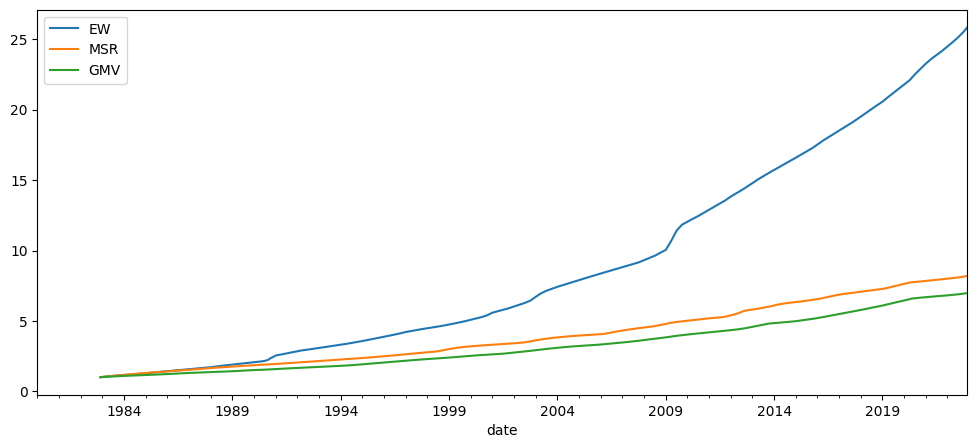

In [6]:
from scipy.optimize import minimize

def backtest_ws(r, weighting, estimation_window=60, **args):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of arguments
    """
    n_periods = r.shape[0]
    # list of overlapping rolling return windows for estimation
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # list of portfolio weights over time
    weights = [weighting(r.iloc[win[0]:win[1]], **args) for win in windows]
    # convert to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

def weight_ew(r):
    w = [ 1/len(r.columns) for x in range(len(r.columns))]
    w = np.array(w)
    return w

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def max_sr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def weight_msr(r):
    er = r.mean()
    cov = r.cov()
    return max_sr(0, er, cov)

def minimize_vol(er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),bounds=bounds)
    return weights.x

def weight_gmv(r):
    er = r.mean()
    cov = r.cov()
    return minimize_vol(er, cov)


# EW: Equal-Weighted, MSR: Maximum Sharpe Ratio, GMV: Global Minimum Volatility
ew_bt = backtest_ws(df_deciles_btm, weighting = weight_ew, estimation_window = 36)
msr_bt = backtest_ws(df_deciles_btm, weighting = weight_msr, estimation_window = 36)
gmv_bt = backtest_ws(df_deciles_btm, weighting = weight_gmv, estimation_window = 36)

btr = pd.DataFrame({"EW": ew_bt, "MSR": msr_bt, "GMV": gmv_bt})
(1+btr).cumprod().plot(figsize=(12,5))


In [5]:
# %load_ext autoreload
# %autoreload 2
import am2023 as am

am.summary_stats(btr.dropna())


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown
EW,0.084519,0.012529,4.675825,4.675825,4.235344,0.0
MSR,0.053933,0.007610,1.648296,1.648296,3.061079,0.0
GMV,0.049668,0.004087,0.603135,0.603135,4.683763,0.0
